# Microarray Analysis of Gene Expression. Differential Analysis

The differential expression analysis aims at identifying the genes whose expression levels change between two sample groups. For the differential expression (DE) analysis, we use R package Limma as part of a customised expression pipeline.

At this point, expression and clinical datasets are expected to be clean/preprocessed, containing the same samples and in the same order and ready to use in limma. Do a previous preprocessing if needed.

### Read clinical and expression datasets. GSE48350

To have an idea on how the data look like. Not neccesary if you are providing paths to these datasets in the DE step.

In [1]:
datasets=load("/mnt/data/GWES/Microarray/output/GSE48350/objects.RData")
datasets

[1] "phenodata"     "expressionset"

In [7]:
clinicalset=read.table("/mnt/data/GWES/input/clinicalset.GSE48350",stringsAsFactors=T)
dim(clinicalset)
head(clinicalset)

[1] 247   6

,Region,Age,Sex,Status,ApoE,APOEgroup
,<fct>,<int>,<fct>,<fct>,<int>,<fct>
GSM1176196,entorhinalcortex,76,female,Case,33,group3
GSM1176197,entorhinalcortex,86,female,Control,44,group4
GSM1176198,entorhinalcortex,82,female,Case,34,group4
GSM1176199,entorhinalcortex,85,female,Case,23,group2
GSM1176200,entorhinalcortex,90,female,Case,34,group4
GSM1176201,entorhinalcortex,90,female,Case,34,group4


In [8]:
unique(clinicalset$Region)

[1] entorhinalcortex     hippocampus          postcentralgyrus    
[4] superiorfrontalgyrus
4 Levels: entorhinalcortex hippocampus ... superiorfrontalgyrus

In [2]:
# expression data obtained from CEL
expression=read.table("/mnt/data/GWES/Microarray/output/GSE48350/expression_df",check.names = F,header=T)
dim(expression)
head(expression,n=3)

[1] 54675   253

,GSM1176196,GSM1176197,GSM1176198,GSM1176199,GSM1176200,GSM1176201,GSM1176202,GSM1176203,GSM1176204,GSM1176205,...,GSM300331,GSM300332,GSM300333,GSM300335,GSM300338,GSM300339,GSM300340,GSM300341,GSM318840,GSM350078
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1007_s_at,12.040740,11.173363,11.805107,11.520710,11.554977,11.238944,11.924660,11.467062,11.828813,10.403868,...,10.746467,11.263029,11.587320,10.647399,10.739888,11.334689,11.032435,10.514415,10.909077,10.610349
1053_at,6.702574,6.369982,6.232879,6.253487,6.286031,6.524358,6.488864,6.704865,6.500081,6.512391,...,6.826001,6.411964,6.308492,6.780958,6.617161,6.570866,6.752661,6.717355,6.313379,6.442135
117_at,6.097215,5.893449,6.257163,6.211781,6.229210,5.807598,6.338025,6.074785,6.161630,6.061308,...,5.780972,5.959948,6.002889,5.907806,5.916647,5.647911,5.610944,5.999280,6.263555,5.622806


**Note: It is very important that clinical and expression datasets have the same samples and maintain the same order. Check for this if working with the two dataset separated, or merge them and work with the merged dataframe.** rownames(clinicalset) or sample name/ID column must be in the same order as colnames(expressionset)

***or use ReadAffy in the previous step and start this tutorial with a single dataset.**

In [17]:
# keep the expression values for those samples in the clinical dataset
expression=expression[, rownames(clinicalset)]
dim(expression)

[1] 54675   247

In [19]:
table(colnames(expression) == rownames(clinicalset))


TRUE 
 247 

**Suggested function to keep the same samples in both datasets and in the same order.** It is very useful for heatmaps to create rownames in the expressionset as a combination of conditions from the clinicalset.

In [20]:
# Keep the same samples in both datasets and in the same order
# 1st param: clinical dataframe
# 2nd param: expression dataframe
# returns a list containing the new clinicalset as first element and new expression set as the second element
# optional: create rownames in expressionset as a combination of conditions from clinicalset. Very useful for heatmaps in DE
keepCommonSamplesDF_function<-function(clinicalset,expression.df){  
    merged.df=merge(t(expression.df),clinicalset,by= "row.names")
    # optional - customise
    rownames(merged.df)<-paste(merged.df$Row.names,merged.df$Status,merged.df$APOEgroup,sep="_")
    ncols<-ncol(merged.df)-ncol(clinicalset) # remove columns from clinical data, bear in mind the clinical.match column
    new.expr<-t(merged.df[, 2:ncols] ) # 1st column is Row.names that merge command creates
    from=ncols+1
    to=dim(merged.df)[2]
    new.clinicalset<-merged.df[, from:to]
    return(list(new.clinicalset,new.expr))
}

In [21]:
# call keepCommonSamplesDF function to get clinical and expression sets containing matching samples
sets=keepCommonSamplesDF_function(clinicalset,expression) 
clinicalset.common=sets[[1]]
dim(clinicalset.common)
expr.common=sets[[2]]
dim(expr.common)

[1] 247   6

[1] 54675   247

Check that the datasets are correct and keepCommonSamplesDF function fits your needs.

In [22]:
head(clinicalset.common,n=3)
head(expr.common,n=3)

,Region,Age,Sex,Status,ApoE,APOEgroup
,<fct>,<int>,<fct>,<fct>,<int>,<fct>
GSM1176196_Case_group3,entorhinalcortex,76,female,Case,33,group3
GSM1176197_Control_group4,entorhinalcortex,86,female,Control,44,group4
GSM1176198_Case_group4,entorhinalcortex,82,female,Case,34,group4


,GSM1176196_Case_group3,GSM1176197_Control_group4,GSM1176198_Case_group4,GSM1176199_Case_group2,GSM1176200_Case_group4,GSM1176201_Case_group4,GSM1176202_Case_group4,GSM1176203_Case_group4,GSM1176204_Case_group4,GSM1176205_Case_group3,...,GSM300331_Control_group2,GSM300332_Control_group4,GSM300333_Control_group4,GSM300335_Control_group4,GSM300338_Control_group3,GSM300339_Control_group3,GSM300340_Control_group3,GSM300341_Control_group3,GSM318840_Control_group3,GSM350078_Control_group4
1007_s_at,12.040740,11.173363,11.805107,11.520710,11.554977,11.238944,11.924660,11.467062,11.828813,10.403868,...,10.746467,11.263029,11.587320,10.647399,10.739888,11.334689,11.032435,10.514415,10.909077,10.610349
1053_at,6.702574,6.369982,6.232879,6.253487,6.286031,6.524358,6.488864,6.704865,6.500081,6.512391,...,6.826001,6.411964,6.308492,6.780958,6.617161,6.570866,6.752661,6.717355,6.313379,6.442135
117_at,6.097215,5.893449,6.257163,6.211781,6.229210,5.807598,6.338025,6.074785,6.161630,6.061308,...,5.780972,5.959948,6.002889,5.907806,5.916647,5.647911,5.610944,5.999280,6.263555,5.622806


### Differential Expression

In [50]:
# Import differential expression functions
source("/home/guess/scripts/diffExpressionPipeline.R")

In [36]:
# Shows the code in a help window. You can also open it in an editor at /home/guess/scripts/diffExpressionPipeline.R
# If you need to modify any function, just rewrite it and execute it here. 
# Jupyter will take the last changes for the same function name
file.show("/home/guess/scripts/diffExpressionPipeline.R")

**Call diff_analysis_function from the pipeline scrips.**

This function performs a differential analysis over the dataset supplied and it is customisable via the input parameters. Specify the conditions you want to do the contrast on. 
It is possible to perform de DE over a subset of the data. Read the user manual to know more.

- 1st parameter, input.path: path where the clinical and expression sets are stored. Optional if you supply the sets as R dataframes
- 2nd parameter, clinicalset: clinicalset dataframe or file name that points to the dataframe in the provided path
- 3rd parameter, expression: expression dataframe or file name that points to the dataframe in the provided path. Probes as rows, samples as columns. Rownames(clinicalset) must be in the same order as names(expressionset)
- 4-7th parameters: parameters used in limma for Diferential Expression. 4th and 5th will be used as contrast: condition1 - condition2 (i.e. case-control) 
    - 4th, DE.cond1: first condition that satisfied the first group your are comparing. i.e "case"
    - 5th, DE.cond2: second condition that satisfied the second group your are comparing. i.e "control"
    - 6th, DE.variable: column name from the clinical dataframe containing the condition 
    - 7th, DE.covariates: optional - character string separated by commas indicating other variables (column names from clinical data) to include as covariates in limma (to adjust for these covariates excluding their effect)
- 8-9th parameters are optional and needed if you want to do diff analysis on a subset of the original data (i.e. only in females)
    - 8th parameter, subset.variable: column name from the clinical dataframe to be used to subset both clinical and expr dataframes
    - 9th parameter, subset.value: value of column name from the clinical df to be used to subset
- 10th parameter, output.path: optional - output path to store limma table as a result (default to current directory)
- 11th parameter, out.name: optional - output file name
- 12th parameter, platform: platform/chip 
- 13th parameter, nheatmap: optional - number of probes to be represented in the heatmap plot (probes are ordered by best p value; default 50)

**Case versus Control in hippocampus - corrected for age and sex**


####  Case  versus  Control  ####

## Subset  Region hippocampus  ##


Warning message in if (class(expression) == "character") {:
"the condition has length > 1 and only the first element will be used"



dim(clinicalset)  247 6
dim(expr)  54675 247
Subseting datasets to keep those subjects belonging to provided conditions:  Case  and  Control
dim(clinical.subset)  247 6
dim(expr.subset)  54675 247
Subseting datasets by  hippocampus
dim(clinical.subset)  60 6
dim(expr.subset)  54675 60

== Doing limma == 

model formula:  ~0 + clinicalset[[DE.variable]]+clinicalset[[DE.covariates[1]]]+clinicalset[[DE.covariates[2]]]

design matrix: 
  Case Control clinicalset..DE.covariates.1...male clinicalset..DE.covariates.2...
1    1       0                                   0                              60
2    1       0                                   0                              76
3    1       0                                   0                              79


contrast:  Case-Control 


limma topTable: 
                 logFC       CI.L       CI.R   AveExpr         t      P.Value   adj.P.Val        B
214306_at   -0.6395910 -0.8491280 -0.4300540  7.952634 -6.107304 8.460282e-08 0.002425

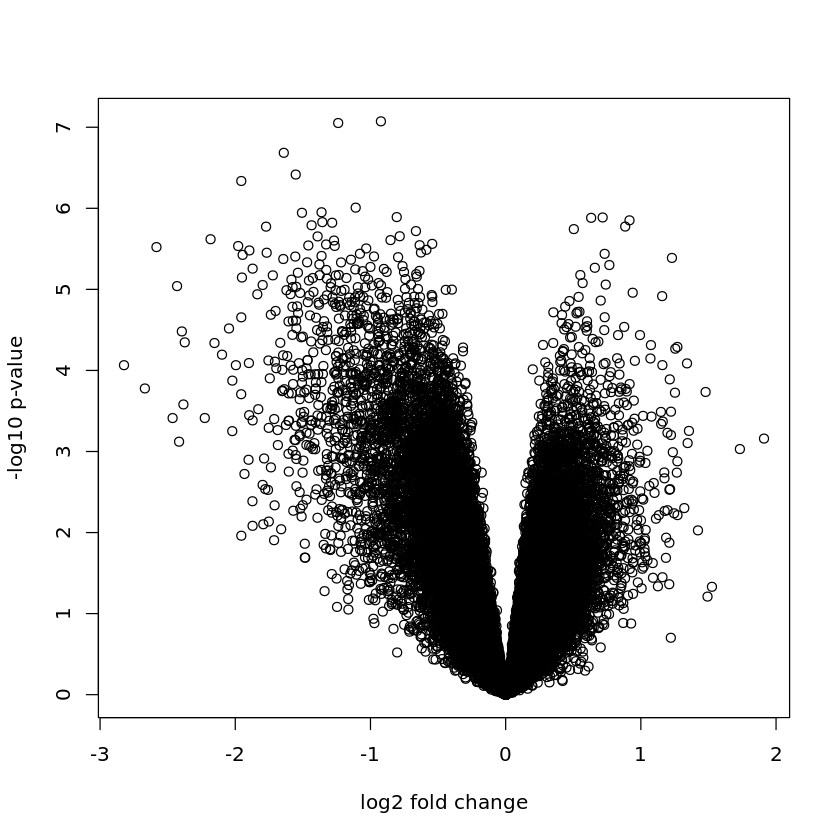

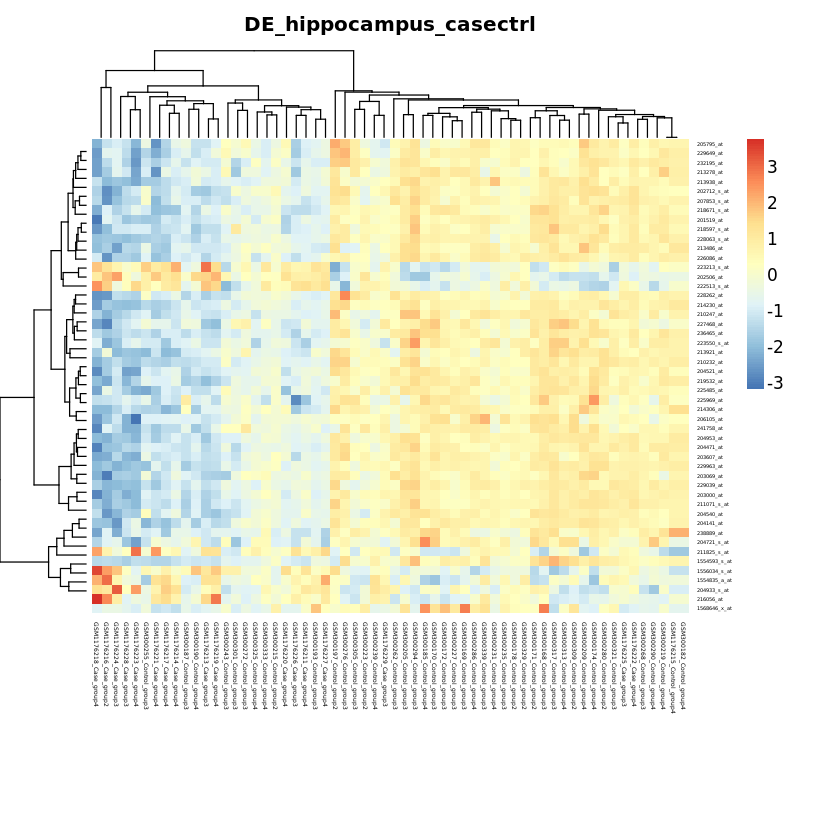

In [51]:
#input.path="" # We are providing the dataset objects but the input path and file names are possible. Internally the function uses read.table(paste(input.path,clinicalset,sep="/"),check.names = F)
output.path="/mnt/data/GWES/Microarray/output/GSE48350"
diff_analysis_function(clinicalset = clinicalset.common,expression = expr.common,DE.cond1 = "Case",DE.cond2 = "Control",DE.variable = "Status",DE.covariates=c("Sex","Age"),subset.variable="Region",subset.value="hippocampus",output.path, out.name="DE_hippocampus_casectrl",platform = "570")


**With pca**


####  Case  versus  Control  ####

## Subset  Region hippocampus  ##


Warning message in if (class(expression) == "character") {:
"the condition has length > 1 and only the first element will be used"



dim(clinicalset)  247 6
dim(expr)  54675 247
Subseting datasets to keep those subjects belonging to provided conditions:  Case  and  Control
dim(clinical.subset)  247 6
dim(expr.subset)  54675 247
Subseting datasets by  hippocampus
dim(clinical.subset)  60 6
dim(expr.subset)  54675 60

== Doing limma == 

model formula:  ~0 + clinicalset[[DE.variable]]+clinicalset[[DE.covariates[1]]]+clinicalset[[DE.covariates[2]]]

design matrix: 
  Case Control clinicalset..DE.covariates.1...male clinicalset..DE.covariates.2...
1    1       0                                   0                              60
2    1       0                                   0                              76
3    1       0                                   0                              79


contrast:  Case-Control 


limma topTable: 
                 logFC       CI.L       CI.R   AveExpr         t      P.Value   adj.P.Val        B
214306_at   -0.6395910 -0.8491280 -0.4300540  7.952634 -6.107304 8.460282e-08 0.002425

Loading required package: pkgmaker

Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 7/8

  To enable shared memory capabilities, try: install.extras('
NMF
')



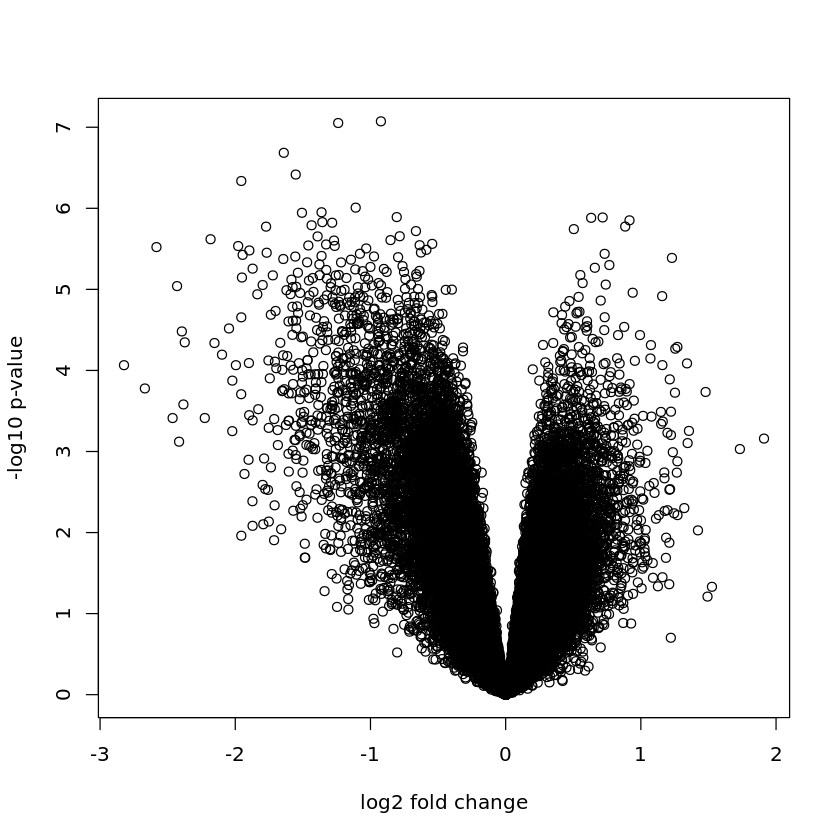

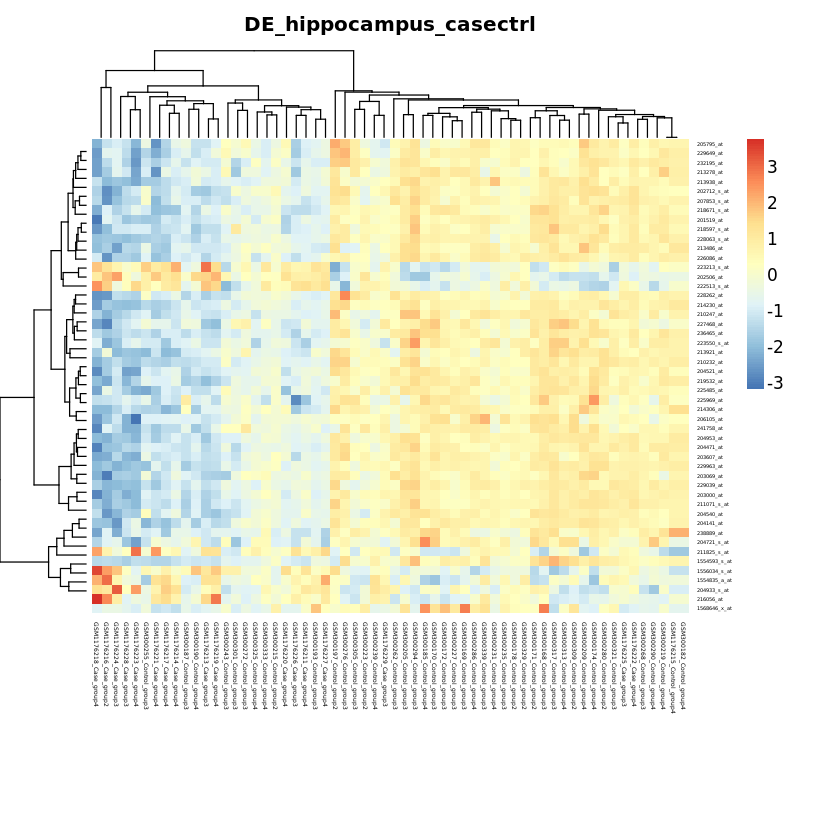

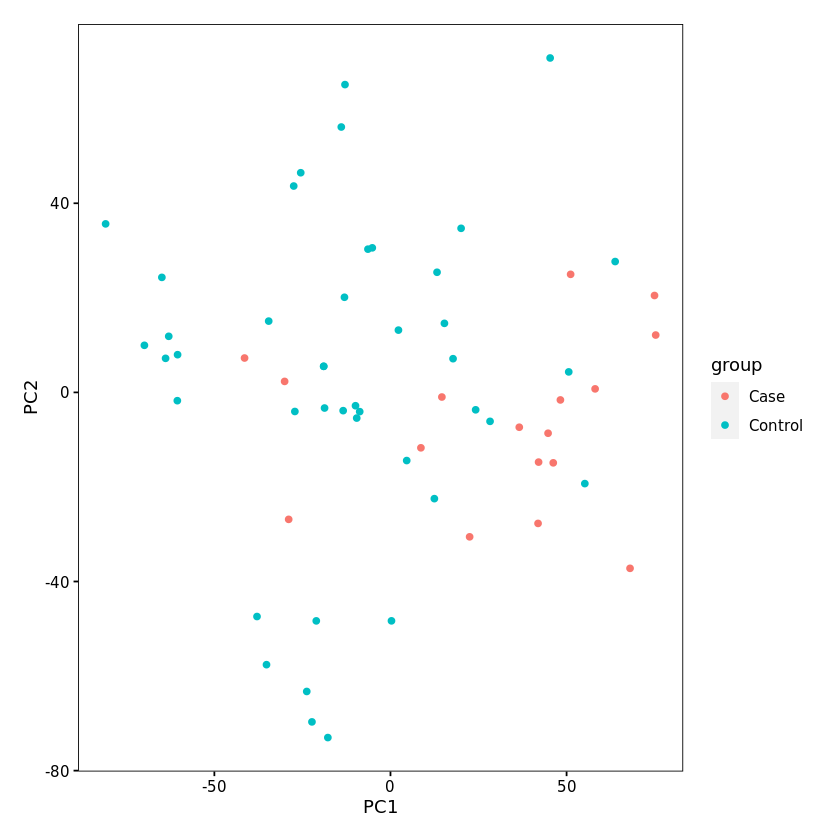

In [35]:
#input.path="" # We are providing the dataset objects but the input path and file names are possible. Internally the function uses read.table(paste(input.path,clinicalset,sep="/"),check.names = F)
output.path="/mnt/data/GWES/Microarray/output/GSE48350"
diff_analysis_function(clinicalset = clinicalset.common,expression = expr.common,DE.cond1 = "Case",DE.cond2 = "Control",DE.variable = "Status",DE.covariates=c("Sex","Age"),subset.variable="Region",subset.value="hippocampus",output.path, out.name="DE_hippocampus_casectrl",platform = "570")


**APOE group 2 versus group 3 in postcentralgyrus - corrected for age and sex**


####  group2  versus  group3  ####

## Subset  Region postcentralgyrus  ##


Warning message in if (class(expression) == "character") {:
"the condition has length > 1 and only the first element will be used"



dim(clinicalset)  247 6
dim(expr)  54675 247
Subseting datasets to keep those subjects belonging to provided conditions:  group2  and  group3
dim(clinical.subset)  147 6
dim(expr.subset)  54675 147
Subseting datasets by  postcentralgyrus
dim(clinical.subset)  40 6
dim(expr.subset)  54675 40

== Doing limma == 

model formula:  ~0 + clinicalset[[DE.variable]]+clinicalset[[DE.covariates[1]]]+clinicalset[[DE.covariates[2]]]

design matrix: 
  group2 group3 clinicalset..DE.variable..group4 clinicalset..DE.covariates.1...male clinicalset..DE.covariates.2...
1      0      1                                0                                   0                              76
2      1      0                                0                                   0                              85
3      0      1                                0                                   0                              85


contrast:  group2-group3 
Coefficients not estimable: clinicalset..DE.variable..group4 

Warning message:
"Partial NA coefficients for 54675 probe(s)"




limma topTable: 
                 logFC        CI.L        CI.R  AveExpr         t      P.Value adj.P.Val         B
240580_at    0.3380663  0.16354940  0.51258328 4.260922  3.916943 0.0003466976 0.9999566 -1.106712
230140_at    0.2114303  0.09973494  0.32312561 4.312679  3.827499 0.0004520453 0.9999566 -1.251814
1560652_at  -0.4615195 -0.70826042 -0.21477864 5.553257 -3.782090 0.0005167961 0.9999566 -1.325197
233764_s_at  0.2315938  0.10006992  0.36311765 6.342944  3.560453 0.0009847208 0.9999566 -1.680109
208148_at    0.1653480  0.06948798  0.26120811 3.468816  3.487741 0.0012125839 0.9999566 -1.795168
236634_at   -0.2365906 -0.37515485 -0.09802633 4.721317 -3.452464 0.0013405857 0.9999566 -1.850712
237464_at    0.2929400  0.12042883  0.46545119 6.780738  3.433558 0.0014144121 0.9999566 -1.880401
223307_at   -0.1785383 -0.28499795 -0.07207865 5.629321 -3.391012 0.0015950364 0.9999566 -1.947004
241463_at    0.1571077  0.06219071  0.25202463 4.370171  3.346852 0.0018057221 0.9999566 -

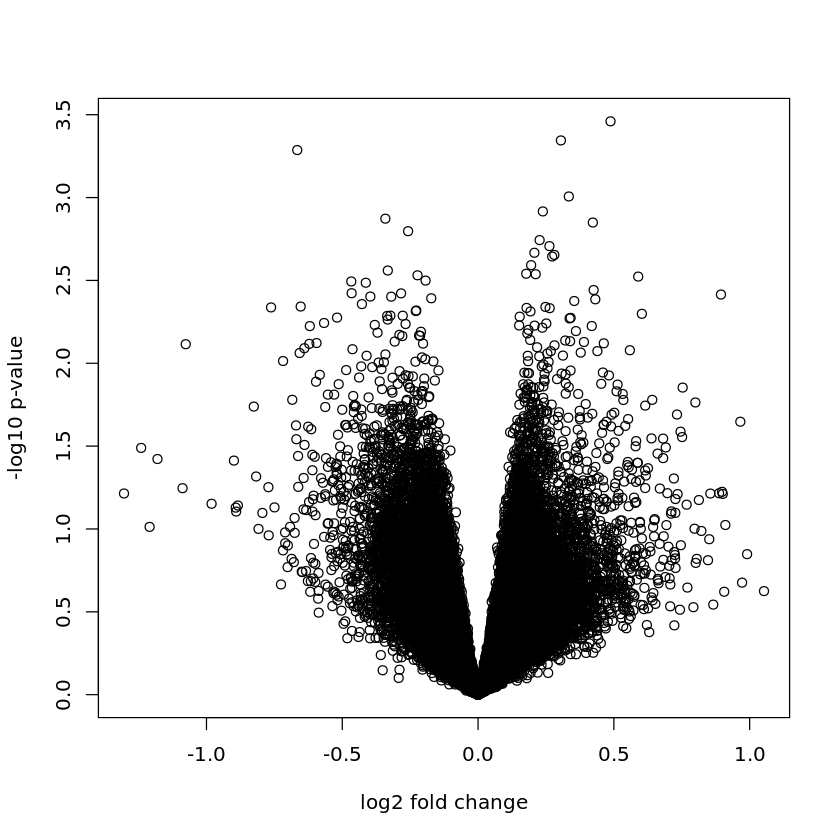

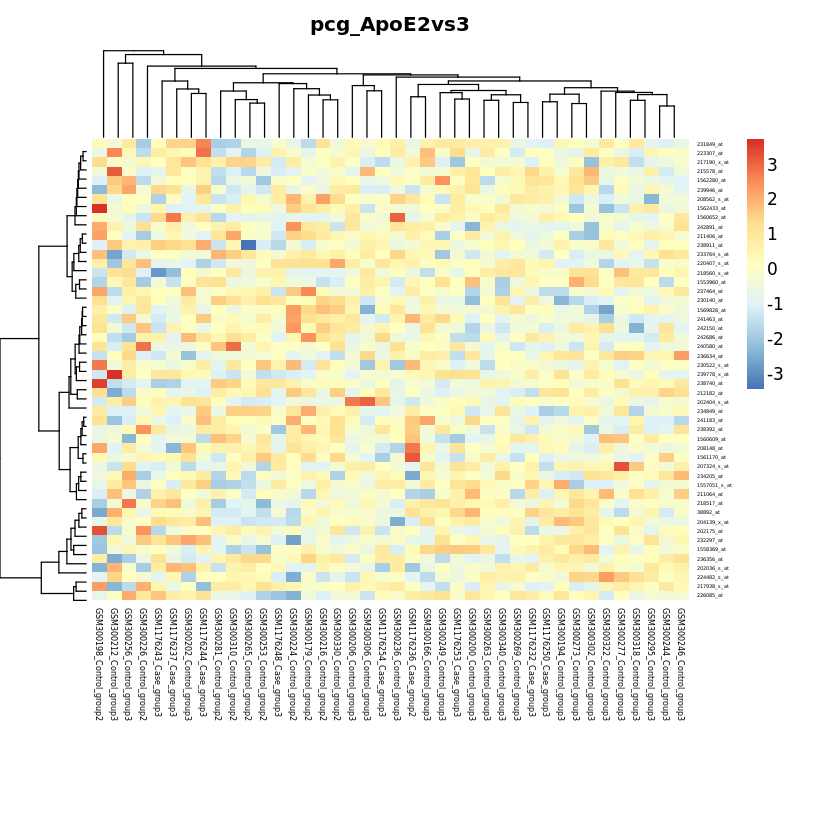

In [52]:
output.path="/mnt/data/GWES/Microarray/output/GSE48350"
diff_analysis_function(clinicalset = clinicalset.common,expression = expr.common,DE.cond1 = "group2",DE.cond2 = "group3",DE.variable = "APOEgroup",DE.covariates=c("Sex","Age"),subset.variable="Region", subset.value="postcentralgyrus",output.path,out.name="pcg_ApoE2vs3",platform = "570")


**With pca**


####  group2  versus  group3  ####

## Subset  Region postcentralgyrus  ##


Warning message in if (class(expression) == "character") {:
"the condition has length > 1 and only the first element will be used"



dim(clinicalset)  247 6
dim(expr)  54675 247
Subseting datasets to keep those subjects belonging to provided conditions:  group2  and  group3
dim(clinical.subset)  147 6
dim(expr.subset)  54675 147
Subseting datasets by  postcentralgyrus
dim(clinical.subset)  40 6
dim(expr.subset)  54675 40

== Doing limma == 

model formula:  ~0 + clinicalset[[DE.variable]]+clinicalset[[DE.covariates[1]]]+clinicalset[[DE.covariates[2]]]

design matrix: 
  group2 group3 clinicalset..DE.variable..group4 clinicalset..DE.covariates.1...male clinicalset..DE.covariates.2...
1      0      1                                0                                   0                              76
2      1      0                                0                                   0                              85
3      0      1                                0                                   0                              85


contrast:  group2-group3 
Coefficients not estimable: clinicalset..DE.variable..group4 

Warning message:
"Partial NA coefficients for 54675 probe(s)"




limma topTable: 
                 logFC        CI.L        CI.R  AveExpr         t      P.Value adj.P.Val         B
240580_at    0.3380663  0.16354940  0.51258328 4.260922  3.916943 0.0003466976 0.9999566 -1.106712
230140_at    0.2114303  0.09973494  0.32312561 4.312679  3.827499 0.0004520453 0.9999566 -1.251814
1560652_at  -0.4615195 -0.70826042 -0.21477864 5.553257 -3.782090 0.0005167961 0.9999566 -1.325197
233764_s_at  0.2315938  0.10006992  0.36311765 6.342944  3.560453 0.0009847208 0.9999566 -1.680109
208148_at    0.1653480  0.06948798  0.26120811 3.468816  3.487741 0.0012125839 0.9999566 -1.795168
236634_at   -0.2365906 -0.37515485 -0.09802633 4.721317 -3.452464 0.0013405857 0.9999566 -1.850712
237464_at    0.2929400  0.12042883  0.46545119 6.780738  3.433558 0.0014144121 0.9999566 -1.880401
223307_at   -0.1785383 -0.28499795 -0.07207865 5.629321 -3.391012 0.0015950364 0.9999566 -1.947004
241463_at    0.1571077  0.06219071  0.25202463 4.370171  3.346852 0.0018057221 0.9999566 -

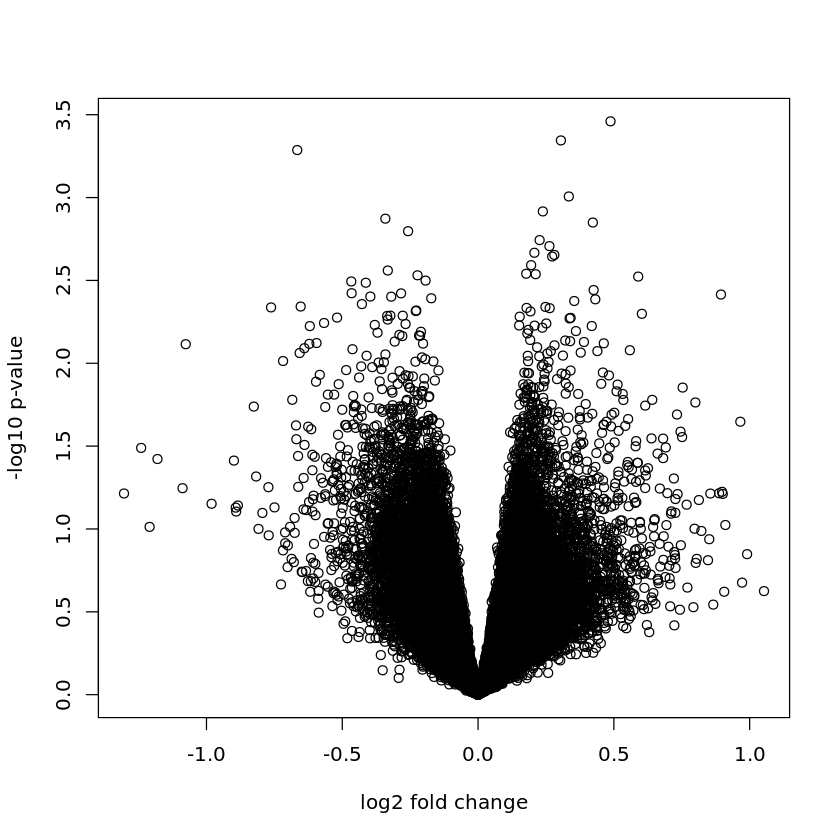

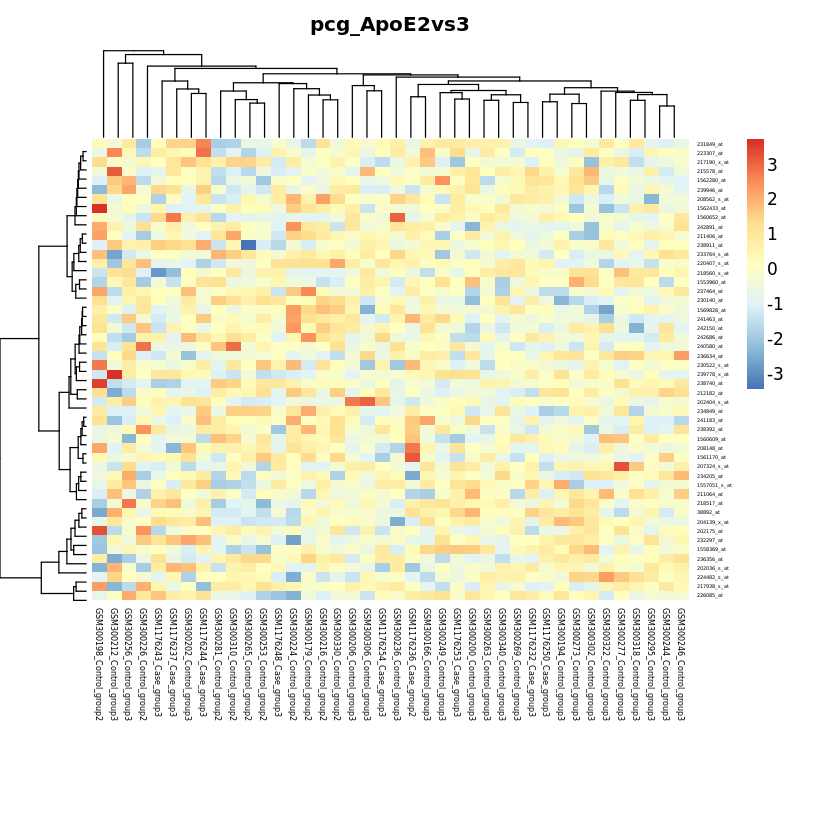

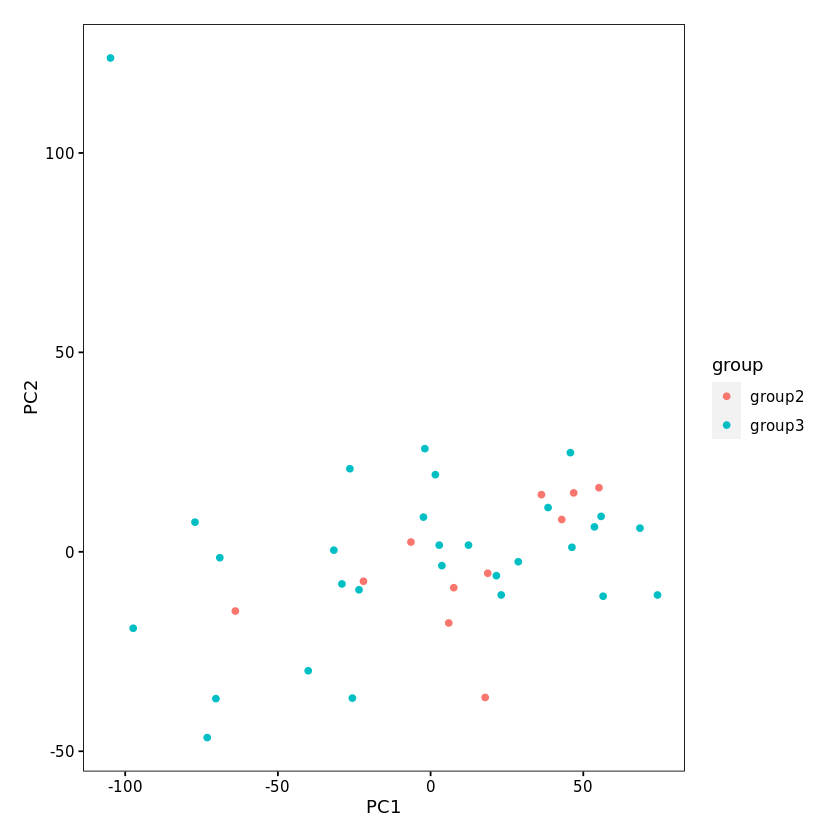

In [37]:
output.path="/mnt/data/GWES/Microarray/output/GSE48350"
diff_analysis_function(clinicalset = clinicalset.common,expression = expr.common,DE.cond1 = "group2",DE.cond2 = "group3",DE.variable = "APOEgroup",DE.covariates=c("Sex","Age"),subset.variable="Region", subset.value="postcentralgyrus",output.path,out.name="pcg_ApoE2vs3",platform = "570")
